
# Project : 개선된 U - Net 모델 만들기

U-Net을 통한 시맨틱 세그멘테이션 결과가 충분히 만족스러우신가요? 어느정도 동작하는 것 같긴 하지만 좀더 개선할 여지도 보일 것입니다.

2018년에 U-Net++라는 논문이 나왔습니다. 이 논문은 기존에 아주 단순하면서도 세그멘테이션에서 효과를 발휘했던 U-Net의 네트워크 구조에 DenseNet의 아이디어를 가미하여 성능을 개선한 모델입니다.

그래서 모델의 구조 자체는 아래 그림에서 보는 것처럼 별다른 설명이 없이도 직관적으로 이해가 가능한 수준입니다. 오늘 소개되었던 U-Net의 모델 코드를 조금만 수정 확장하면 충분히 구현할 수 있을 것입니다. 그래서 오늘의 과제는 바로 U-Net++ 모델을 스스로의 힘으로 직접 구현해 보고, U-Net을 활용했던 도로 세그멘테이션 태스크에 적용하여 U-Net을 썼을 때보다 성능이 향상되었음을 확인해 보는 것입니다. 정성적으로는 두 모델의 세그멘테이션 결과를 시각화해서 비교해 볼 수 있을 것이고, 정량적으로는 동일 이미지에 대한 IoU값을 비교해 보면 될 것입니다.


![](https://aiffelstaticprd.blob.core.windows.net/media/images/GC-5-P-UNPP.max-800x600.png)

+ 참고 : [U-Net++ 저자 블로그](https://sh-tsang.medium.com/review-unet-a-nested-u-net-architecture-biomedical-image-segmentation-57be56859b20)

<br></br>
## Step 1. KITTI 데이터셋 수집과 구축

다운받아 둔 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축합니다. 이때 주의할 점이 있습니다. U-Net++는 내부적인 메모리 사용량이 U-Net보다 꽤 많아집니다. 8GB의 GPU 메모리를 가진 모델의 경우 학습데이터의 배치 사이즈를 16->4 로 줄여서 설정하시기를 권합니다.

<br></br>
## Step 2. U-Net++ 모델의 구현

U-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 수 있을 것입니다. 이 과정을 통해 U-Net 자체에 대한 이해도도 증진될 것입니다.  
그 외 적절히 U-Net의 백본구조, 기타 파라미터 변경 등을 통해 추가적인 성능향상이 가능할수도 있습니다.

<br></br>
## Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

두 모델의 정량적, 정성적 성능을 비교해 봅시다. 시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견하실 수 있을 것입니다.

## Step 1. KITTI 데이터셋 수집과 구축

In [1]:
#필요한 라이브러리를 로드합니다. 

import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [2]:
# Albumentation 에서 `Compose()` 메서드의 활용을 위한 build_augmentation 함수 생성

from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

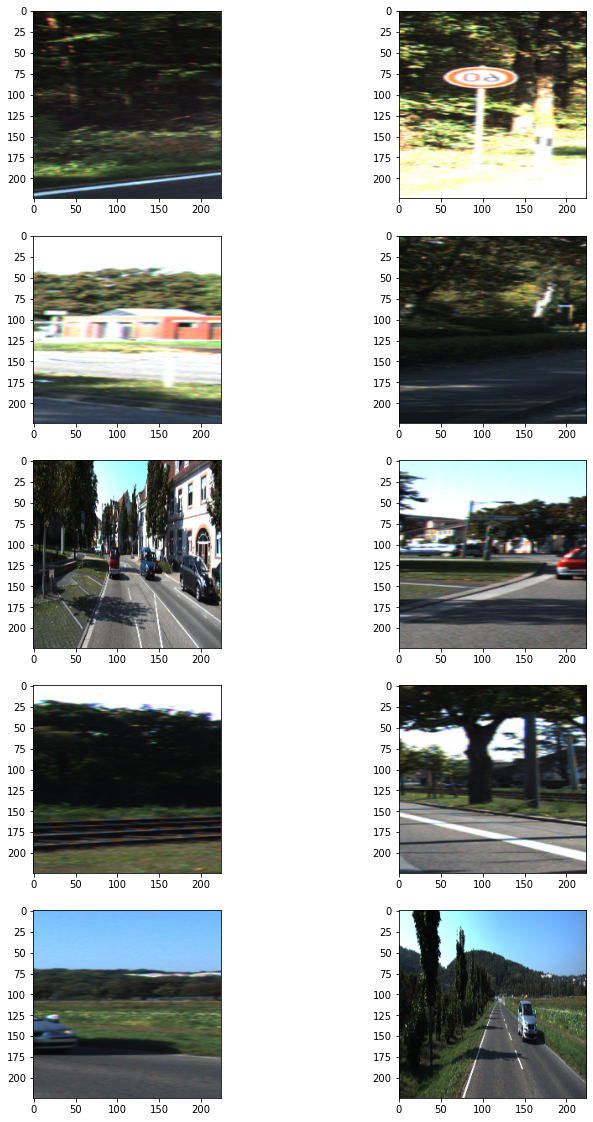

In [3]:
# 훈련 데이터셋에 augmentation 적용

import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [4]:
# 데이터 셋 구성

class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## Step 2. U-Net++ 모델의 구현

In [6]:
# U - Net 모델

def build_model(input_shape=(224, 224, 3)):
    model = None
    # TODO: input_shape에 따라 U-Net을 만들어주세요
    # 이때 model은 fully convolutional해야 합니다.
   
    inputs = Input(input_shape)

    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

    #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5)) 
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [7]:
model = build_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_unet.h5++'
model.save(model_path)  #학습한 모델을 저장해 주세요.

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
11/11 [==============================] - 7s 605ms/step - loss: 0.6552 - val_loss: 0.5007
Epoch 2/100
11/11 [==============================] - 7s 614ms/step - loss: 0.1864 - val_loss: 0.0419
Epoch 3/100
11/11 [==============================] - 7s 612ms/step - loss: 0.0367 - val_loss: 0.0320
Epoch 4/100
11/11 [==============================] - 7s 609ms/step - loss: 0.0294 - val_loss: 0.0245
Epoch 5/100
11/11 [==============================] - 7s 612ms/step - loss: 0.0262 - val_loss: 0.0393
Epoch 6/100
11/11 [==============================] - 7s 612ms/step - loss: 0.0301 - val_loss: 0.0244
Epoch 7/100
11/11 [==============================] - 7s 612ms/step - loss: 0.0287 - val_loss: 0.0211
Epoch 8/100
11/11 [==============================] - 7s 613ms/step - loss: 0.0235 - val_loss: 0.0334
Epoch 9/100
11/11 [==============================] - 7s 619ms/step - loss: 0.0268 - val_loss: 0.0350
Epoch 10/100
11

11/11 [==============================] - 6s 571ms/step - loss: 0.0206 - val_loss: 0.0273
Epoch 77/100
11/11 [==============================] - 6s 570ms/step - loss: 0.0208 - val_loss: 0.0235
Epoch 78/100
11/11 [==============================] - 6s 570ms/step - loss: 0.0169 - val_loss: 0.0215
Epoch 79/100
11/11 [==============================] - 6s 569ms/step - loss: 0.0157 - val_loss: 0.0219
Epoch 80/100
11/11 [==============================] - 6s 571ms/step - loss: 0.0156 - val_loss: 0.0202
Epoch 81/100
11/11 [==============================] - 6s 568ms/step - loss: 0.0135 - val_loss: 0.0222
Epoch 82/100
11/11 [==============================] - 6s 568ms/step - loss: 0.0150 - val_loss: 0.0207
Epoch 83/100
11/11 [==============================] - 6s 570ms/step - loss: 0.0144 - val_loss: 0.0205
Epoch 84/100
11/11 [==============================] - 6s 568ms/step - loss: 0.0179 - val_loss: 0.0209
Epoch 85/100
11/11 [==============================] - 6s 568ms/step - loss: 0.0142 - val_loss: 

In [8]:
# U - Net ++ 모델

def build_model_upp(input_shape=(224, 224, 3)):
    model = None
    # TODO: input_shape에 따라 U-Net을 만들어주세요
    # 이때 model은 fully convolutional해야 합니다.
   
    inputs = Input(input_shape)

    x00 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    pool0 = MaxPooling2D(pool_size=(2, 2))(x00)
    
    x10 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool0)
    x01 = concatenate([x00, UpSampling2D(size=(2,2))(x10)], axis=3)
    x01 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x01)
    pool1 = MaxPooling2D(pool_size=(2, 2))(x10)
    
    x20 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    x11 = concatenate([x10, UpSampling2D(size=(2,2))(x20)], axis=3)
    x11 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x11)
    x02 = concatenate([x00, x01, UpSampling2D(size=(2,2))(x11)], axis=3)
    x02 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x02)
    pool2 = MaxPooling2D(pool_size=(2, 2))(x20)
    
    x30 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    x21 = concatenate([x20, UpSampling2D(size=(2,2))(x30)], axis=3)
    x21 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x21)
    x12 = concatenate([x10, x11, UpSampling2D(size=(2,2))(x21)], axis=3)
    x12 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x12)
    x03 = concatenate([x00, x01, x02, UpSampling2D(size=(2,2))(x12)], axis=3)
    x03 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x03)
    pool3 = MaxPooling2D(pool_size=(2, 2))(x30)
    
    x40 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    
    x31 = concatenate([x30, UpSampling2D(size=(2,2))(x40)], axis=3)
    x31 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x31)
    
    x22 = concatenate([x20, x21, UpSampling2D(size=(2,2))(x31)], axis=3)
    x22 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x22)
    
    x13 = concatenate([x10, x11, x12, UpSampling2D(size=(2,2))(x22)], axis=3)
    x13 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x13)  
    
    x04 = concatenate([x00, x01, x02, x03, UpSampling2D(size=(2,2))(x13)], axis=3)
    x04 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x04)  
    
    x = Conv2D(1, 1, activation='sigmoid')(x04)

    # deep supervision
    output_1 = Conv2D(1, 1, activation='sigmoid')(x01)
    output_2 = Conv2D(1, 1, activation='sigmoid')(x02)
    output_3 = Conv2D(1, 1, activation='sigmoid')(x03)
    output_4 = Conv2D(1, 1, activation='sigmoid')(x04)

    outputs = average([output_1, output_2, output_3, output_4])
    ensemble_model = Model(inputs=inputs, outputs=outputs)

    return ensemble_model

In [9]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path,
    batch_size=4,
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    batch_size=4,
    augmentation=test_preproc,
    is_train=False
)

In [10]:
model_upp = build_model_upp()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_unet++.h5++'
model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
43/43 [==============================] - 9s 216ms/step - loss: 0.1028 - val_loss: 0.0974
Epoch 2/100
43/43 [==============================] - 9s 206ms/step - loss: 0.0814 - val_loss: 0.0821
Epoch 3/100
43/43 [==============================] - 9s 207ms/step - loss: 0.0745 - val_loss: 0.0734
Epoch 4/100
43/43 [==============================] - 9s 205ms/step - loss: 0.0818 - val_loss: 0.0723
Epoch 5/100
43/43 [==============================] - 9s 220ms/step - loss: 0.0731 - val_loss: 0.0690
Epoch 6/100
43/43 [==============================] - 10s 222ms/step - loss: 0.0709 - val_loss: 0.0750
Epoch 7/100
43/43 [==============================] - 9s 221ms/step - loss: 0.0618 - val_loss: 0.0682
Epoch 8/100
43/43 [==============================] - 9s 221ms/step - loss: 0.0689 - val_loss: 0.0682
Epoch 9/100
43/43 [==============================] - 9s 221ms/step - loss: 0.0614 - val_loss: 0.0676
Epoch 10/100
43/43 [==============================] - 9s 220ms/step - loss: 0.0635 - val_l

43/43 [==============================] - 10s 221ms/step - loss: 0.0478 - val_loss: 0.0680
Epoch 79/100
43/43 [==============================] - 10s 222ms/step - loss: 0.1256 - val_loss: 0.0871
Epoch 80/100
43/43 [==============================] - 10s 223ms/step - loss: 0.0705 - val_loss: 0.0759
Epoch 81/100
43/43 [==============================] - 10s 222ms/step - loss: 0.0628 - val_loss: 0.0856
Epoch 82/100
43/43 [==============================] - 10s 223ms/step - loss: 0.0652 - val_loss: 0.0745
Epoch 83/100
43/43 [==============================] - 10s 223ms/step - loss: 0.0571 - val_loss: 0.0696
Epoch 84/100
43/43 [==============================] - 10s 223ms/step - loss: 0.0564 - val_loss: 0.0691
Epoch 85/100
43/43 [==============================] - 10s 222ms/step - loss: 0.0585 - val_loss: 0.0786
Epoch 86/100
43/43 [==============================] - 10s 222ms/step - loss: 0.0559 - val_loss: 0.0656
Epoch 87/100
43/43 [==============================] - 10s 223ms/step - loss: 0.0575 - 

## Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

In [15]:
# 시각화를 위한 함수 생성

def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output

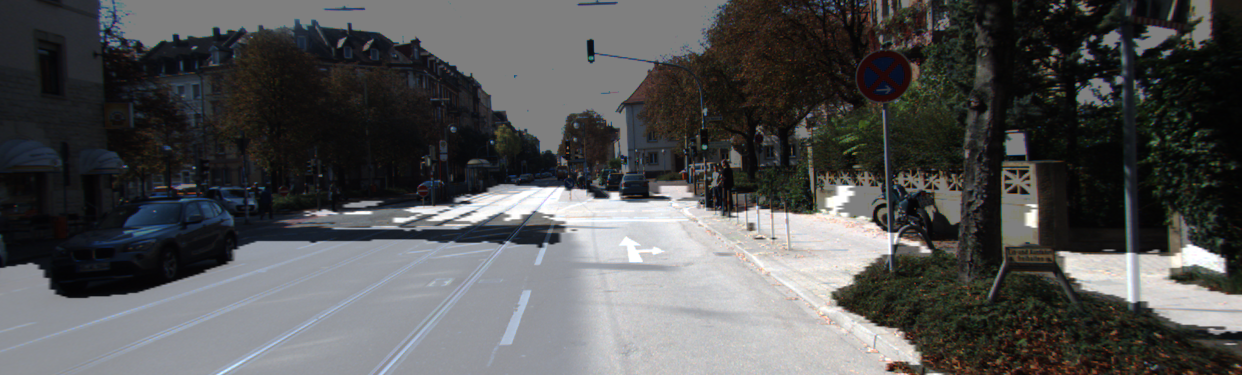

In [16]:
# U - NET 시각화

i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [17]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [18]:
def get_output_exp(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  
    prediction = output/255
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1

        return output, prediction, target
    else:
        return output, prediction, _

In [19]:
# IoU 를 통한 성능 평가

i = 1 
output, prediction, target = get_output_exp(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.751800


0.7518001946156341

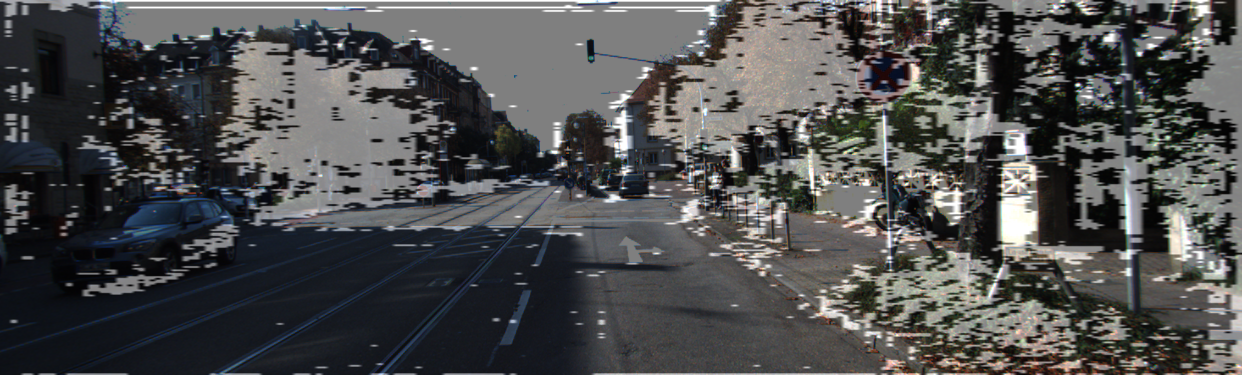

In [20]:
# U - NET PLUSPLUS 시각화

i = 1 
get_output(
     model_upp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [21]:
# IoU 를 통한 성능 평가

i = 1 
output, prediction, target = get_output_exp(
     model_upp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.014644


0.014644267986113882

In [26]:
iou = 0
for i in range(10):
    output, prediction, target = get_output_exp(
         model, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )

    iou += calculate_iou_score(target, prediction)
print(iou/10)

IoU : 0.786400
IoU : 0.751800
IoU : 0.637061
IoU : 0.634257
IoU : 0.571630
IoU : 0.526311
IoU : 0.344094
IoU : 0.795207
IoU : 0.678088
IoU : 0.734872
0.6459719914401909


In [27]:
iou = 0
for i in range(10):
    output, prediction, target = get_output_exp(
         model_upp, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )

    iou += calculate_iou_score(target, prediction)
print(iou/10)

IoU : 0.052191
IoU : 0.014644
IoU : 0.018069
IoU : 0.044780
IoU : 0.021933
IoU : 0.013595
IoU : 0.084826
IoU : 0.056196
IoU : 0.067146
IoU : 0.066606
0.043998591891545924
